In this assignment, you will apply the unsupervised learning methods to your own project.

Example explorations could be:

-    apply PCA for dimension reduction and then apply K-Means to cluster the training data, check how does each cluster relate with labels/values of training data (e.g., does samples from specific clusters all belong to the same class? does the formed clusters provide you better understanding of the training data)
-    apply PCA for dimension reduction and then re-fit the models you've practiced (e.g., tree-based, linear), check how the model performance change (make sure you confirm that the selected PCs explained most of the variance)

To submit:

-    write your code in a jupyter notebook named P4_unsupervised.ipynb
-    Submit P4_unsupervised.ipynb to Gradescope: P4_unsupervised 


Note that in your implementation, we recommend you to:

-    explore parameter settings that could potentially affect your model performance (e.g., #clusters, #principal components), find a model that works best on your data
-    comment on important steps
-    connect model performance with the concept we learn in the lecture
-    discuss pros and cons of each model


In [1]:
# importing important libraries
import os
import numpy as np
import pandas as pd
import re, string

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# for validation
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time


# for ensemble
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# for PCA and clustering
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import scipy 
import gensim
import lucem_illud # package from content analysis class


# for viz
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt


# for NLP
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
from bs4 import BeautifulSoup


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Data Set up


In [2]:
# get the Reddit data
all_df = pd.read_pickle("D:\\hw\\adopt-proj\\newest_all_df.pkl")

In [3]:
all_df[all_df.num_tokens > 25]

In [3]:
truth_df = all_df[all_df.is_adoptee < 2]

### Helper Functions
From p3

In [5]:
# use for model evaluation of classifiers

def mod_eval(clf, X_test, y_test):
    """
    Given a classifier and data print out a classification report and 
    a corresponding ROC-AUC chart to visualize model performance.

    Inputs:
        clf: an sklearn classifier 
        X_test: an array like structure of model testing features 
        y_test: an array like structure of model testing y's
    Return nothing, prints classification report table and plots a ROC-AUC curve
    """
    # find yhats for testing data
    y_pred_test = clf.predict(X_test)
    # model performance on testing set
    print(classification_report(y_test, y_pred_test),"\n")
    
    con_mat = confusion_matrix(y_test, y_pred_test)
    # help displaying a confusion matrix with labels
    # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    labels = ['Non-adoptees', 'Adoptees']
    cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
    cmd.plot(cmap="crest")

    # this portion of the code was aided with the help of Chat GPT
    # https://chat.openai.com/share/c4379ee5-9d59-4632-84aa-6a14b1aaec02

    # find the y_probs
    y_probs = clf.predict_proba(X_test)[:, 1]
    fprs, tprs, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fprs, tprs)
    plt.figure()
    plt.plot(fprs, tprs, color='darkred', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()
    return


def vect_and_split(vectorizer, df, feature_col, y_col):
    """
    Vectorizers a column of text data features, and performs a test-train split
    Inputs:
        vectorizer: the vectorizer to vectorize the feature column
        df: the dataframe
        feature_col: the column of textual data that will act as the features
        y_col: the column containing the y's
    Outputs:
        train and test split for X and y
    """

    # convert the cleaned reviews to vectors
    X = vectorizer.fit_transform(feature_col)
    y = y_col

    # train test split
    train_idx, test_idx = train_test_split(np.arange(df.shape[0]), 
                                           test_size=0.3, 
                                           shuffle=True, random_state=42)

    X_train = X[train_idx]
    y_train = y.iloc[train_idx]

    X_test = X[test_idx]
    y_test = y.iloc[test_idx]

    return X_train, y_train, X_test, y_test

### Let's do train test split for count vectorizer data

In [6]:
# since I am dealing with textual data, we need to vectorize the text to find 
# useful insights into this high dimensional data

# find stop words
stop_words = stopwords.words('english')

# use TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=stop_words, 
                                   max_df=0.9, min_df=3, ngram_range=(1,2))


In [1]:
# train test split
X_train, y_train, X_test, y_test = vect_and_split(tfidf_vectorizer,
                                                  truth_df,
                                                  truth_df.cleaned_post_text, 
                                                  truth_df.is_adoptee)

Instead of using PCA I have opted to use truncated singular value decomposition, a method dimilar to PCA that works better for sparse matrix data (using dense matrices would be too memory intensive for my computer). 

From sklearn:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD

"This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently."

Performing Truncated SVD on TF-IDF vectors is called latent semantic analysis.

I also asked Chat GPT to help better explain the differences between using truncated SVD and PCA.
https://chat.openai.com/share/942a449e-87a5-4cfa-a2c5-8a735683e13d


In [ ]:
tSVD = decomposition.TruncatedSVD(n_components=100)
X_tSVD_train = tSVD.fit_transform(X_train)
X_tSVD_test = tSVD.fit_transform(X_test)

Now lets see how much of the variance is explained by each component

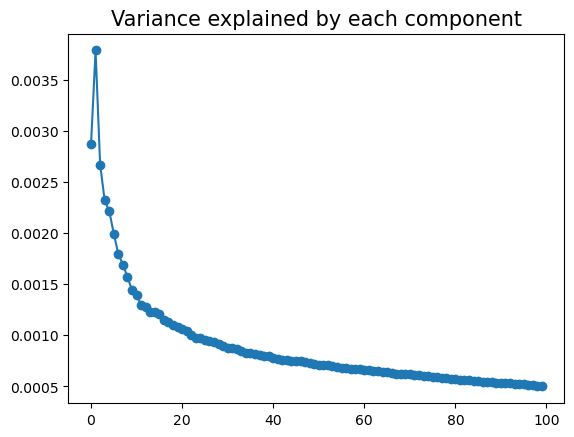

In [ ]:
plt.plot(tSVD.explained_variance_ratio_,'o-')
plt.title('Variance explained by each component', fontsize=15)
plt.show()

We see that each component explains VERY little of the variance by itself, perhaps we want to incorporate around the first 20 or so.

In [ ]:
tSVD = decomposition.TruncatedSVD(n_components=20)
X_tSVD_train = tSVD.fit_transform(X_train)
X_tSVD_test = tSVD.fit_transform(X_test)

In [ ]:
# get the best model from grid CV (from p3)
lr_clf = LogisticRegression(random_state=42,
                            C=0.1,
                            penalty="l2",
                            solver='liblinear').fit(X_tSVD_train, y_train)

              precision    recall  f1-score   support

           0       0.38      0.05      0.09      6461
           1       0.60      0.94      0.73      9692

    accuracy                           0.59     16153
   macro avg       0.49      0.50      0.41     16153
weighted avg       0.51      0.59      0.48     16153
 



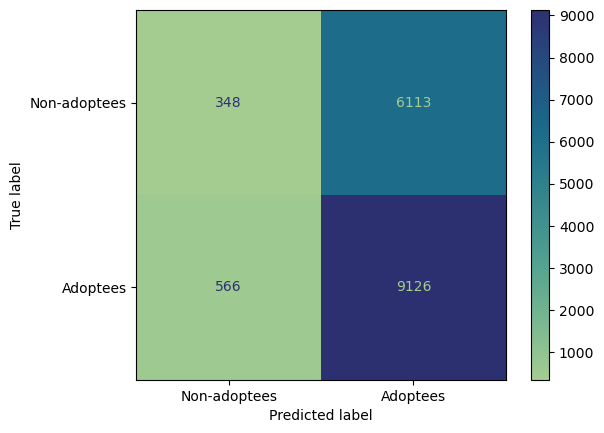

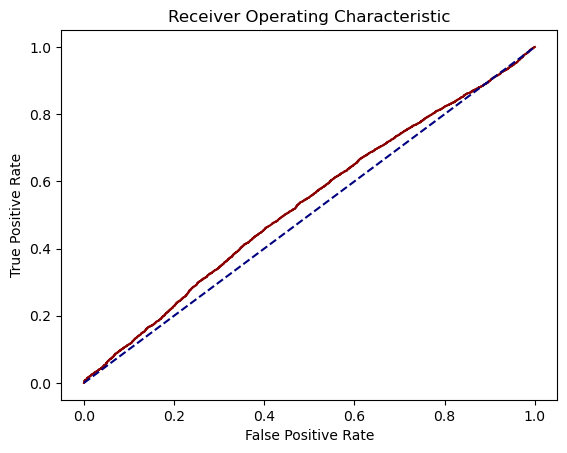

In [ ]:
mod_eval(lr_clf, X_tSVD_test, y_test)

This model performs extremely poorly. The F1 score for non adoptees is only .1. The accuracy is only around .58 From P3, our model performed much better without truncated SVD (total accuracy of .72 and F1 score for non adoptees at .61) From the ROC curve we understand that our model is not much better than random guessing. The obvious con for this model (using truncated SVD to reduce the dimensionality of my word vectors (TF-IDF)) is that the model performed worse. It was not good at predicting whether posts were written by adoptees or not.

#### Let's try a different model

Let's try some grid search to possibly find a good model

In [ ]:
# takes 17 minutes to run
lr_clf = LogisticRegression(random_state=42)
# let's look at both regularization techniques, multiples values of C, and two solvers
parameters = {'penalty':('l1', 'l2'), 
              'C':[0.01, 0.1, 1],
              'solver': ['liblinear']} # 2*4*1 = 8 combinations

grid_cv = GridSearchCV(estimator = lr_clf, 
                       param_grid = parameters, 
                       cv=5).fit(X_tSVD_train, y_train)

In [ ]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.6361705389522065


              precision    recall  f1-score   support

           0       0.45      0.21      0.29      6461
           1       0.61      0.83      0.70      9692

    accuracy                           0.58     16153
   macro avg       0.53      0.52      0.50     16153
weighted avg       0.55      0.58      0.54     16153
 



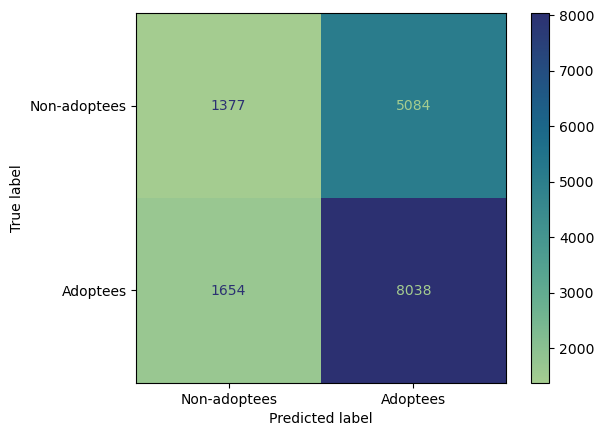

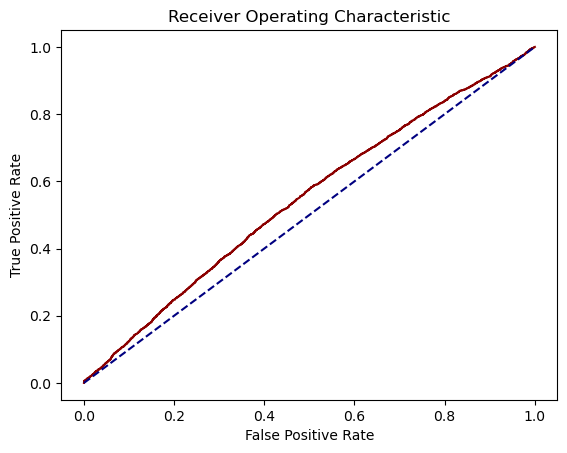

In [ ]:
lr_clf_new = LogisticRegression(random_state=42, 
                                C=1,
                                penalty="l1",
                                solver='liblinear').fit(X_tSVD_train, y_train)

mod_eval(lr_clf_new, X_tSVD_test, y_test)

We see with this model, the accuracy decreases somewhat but the F1 score for non adoptee posts improves somewhat.

### Let's try DT

In [ ]:
DT_clf = DecisionTreeClassifier(random_state=42)
parameters = {'max_depth':[15], 
              'max_leaf_nodes':[20, 100],
              "random_state": [42],
              'max_features': [.8],
              "criterion": ["gini", "entropy", "log_loss"]}

grid_cv = GridSearchCV(estimator = DT_clf,
                       param_grid = parameters,
                       cv=5).fit(X_train, y_train)

In [ ]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.8, 'max_leaf_nodes': 100, 'random_state': 42}
0.6605286564877269


              precision    recall  f1-score   support

           0       0.49      0.31      0.38      6461
           1       0.63      0.79      0.70      9692

    accuracy                           0.60     16153
   macro avg       0.56      0.55      0.54     16153
weighted avg       0.58      0.60      0.57     16153
 



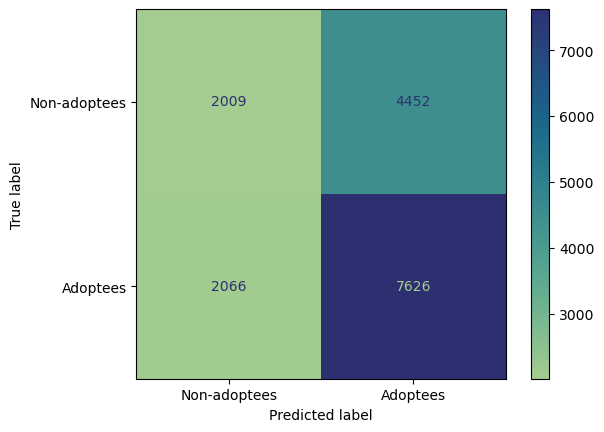

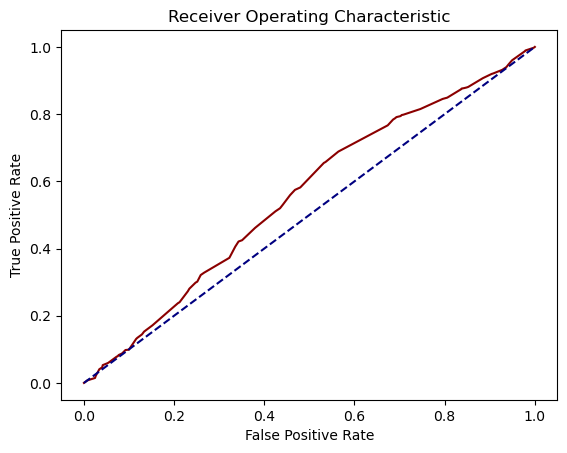

In [ ]:
DT_clf = DecisionTreeClassifier(random_state=42,
                            max_depth=15,
                            max_leaf_nodes=100,
                            max_features=.8,
                            criterion="entropy"
                            ).fit(X_tSVD_train, y_train)

mod_eval(DT_clf, X_tSVD_test, y_test)

Interestingly, the dimension reduced data seems to be performing better with DTs than with Logistic regression. We see here that the overall accuracy is very similar, but the F1 scores for non adoptees keep improving

## Clustering


Let's try to do some clustering to find important topics discussed in these threads.

In [ ]:
def kmeans_visualize(X, k, max_iter=10, rand_seed=0):
    _, ax = plt.subplots(max_iter, figsize=(6.0, 4.6 * max_iter))
    np.random.seed(rand_seed)

    # changed to have more 3 clusters
    colors = np.array([f"C{i}" for i in range(k)])
    
    # Randomly initialize k cluster centroids
    Mu = X[np.random.choice(X.shape[0], k), :]

    # use for loop to repeat the following process until reach the limit
    for i in range(max_iter):

        # assign each data to the closest cluster centroids
        D = -2 * X@Mu.T + (X**2).sum(axis=1)[:, None] + (Mu**2).sum(axis=1)
        y = np.argmin(D, axis=1)

        # visualize the data with the color of its belonging cluster
        ax[i].scatter(X[:, 0], X[:, 1], c=colors[y], alpha=.05)

        # visualize the current cluster centroid
        ax[i].scatter(Mu[:, 0], Mu[:, 1], c='k')

        # Re-compute the cluster centroids
        Mu = np.array([np.mean(X[y == j], axis=0) for j in range(k)])

    # calculate the final loss/error
    loss = np.linalg.norm(X - Mu[np.argmin(D, axis=1), :]) ** 2 / X.shape[0]

    return Mu, y, loss

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(X_tSVD_train)
kmeans.cluster_centers_

array([[ 6.02362763e-02,  1.25359198e-02,  1.42125633e-02,
        -3.18599480e-03,  1.34729195e-02,  4.68959747e-03,
        -1.16871276e-02, -4.03521029e-03, -1.38179876e-03,
         2.61495681e-03,  5.13530069e-03,  2.96061840e-03,
        -6.00438054e-04, -2.22957191e-03,  1.66838321e-03,
        -1.93081124e-03,  3.92792749e-03,  5.87973149e-04,
         8.76366987e-04, -2.42014075e-03],
       [ 1.46273979e-01, -6.31546775e-03, -8.73487891e-03,
        -1.34924026e-04, -1.27521025e-02, -1.62175124e-04,
         1.06024187e-02,  4.97075082e-03,  1.48333767e-03,
        -1.65100295e-03, -3.38001947e-03, -1.34095246e-04,
         7.19904478e-04,  2.17628053e-04,  6.20398255e-06,
         1.73215876e-03, -1.36406448e-03, -1.22087902e-04,
        -1.59245270e-04,  1.18753957e-03]])

              precision    recall  f1-score   support

           0       0.41      0.64      0.50      6461
           1       0.61      0.37      0.46      9692

    accuracy                           0.48     16153
   macro avg       0.51      0.51      0.48     16153
weighted avg       0.53      0.48      0.48     16153
 



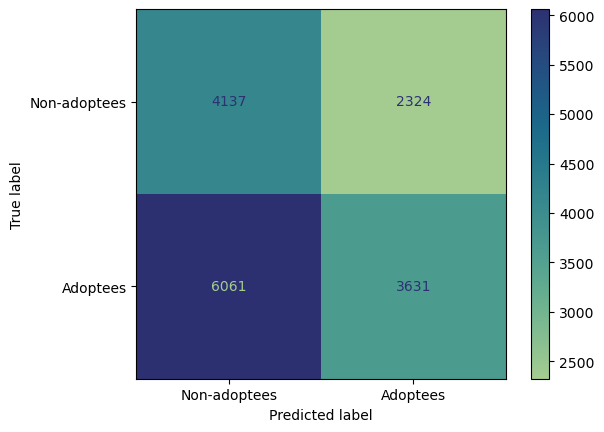

In [ ]:
y_pred_test = kmeans.predict(X_tSVD_test)
# model performance on testing set
print(classification_report(y_test, y_pred_test),"\n")

con_mat = confusion_matrix(y_test, y_pred_test)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

It appears our classification is worse than random again. The accuracy is around 48%. We see that F1 score for both categories is not above 50%. 

Let's visualize the clusters (k=2)

(array([[ 0.14209567, -0.00601752, -0.00784128, -0.0047611 ,  0.00173298,
         -0.00897623,  0.01115416,  0.00088029,  0.00044506, -0.00271632,
         -0.00250568,  0.00106175, -0.00144646,  0.00109445, -0.00041545,
         -0.00168885,  0.00075836, -0.00072663,  0.00030138,  0.00043025],
        [ 0.05883293,  0.01254483,  0.01418984,  0.01005487, -0.00135636,
          0.0078473 , -0.01326626, -0.00022901, -0.00095168,  0.00407176,
          0.00341083, -0.00372393,  0.00432435, -0.00184031,  0.00310515,
          0.00273619, -0.00322318,  0.00230455, -0.00094489, -0.00025279]]),
 array([0, 0, 0, ..., 1, 0, 1], dtype=int64),
 0.03165846444215293)

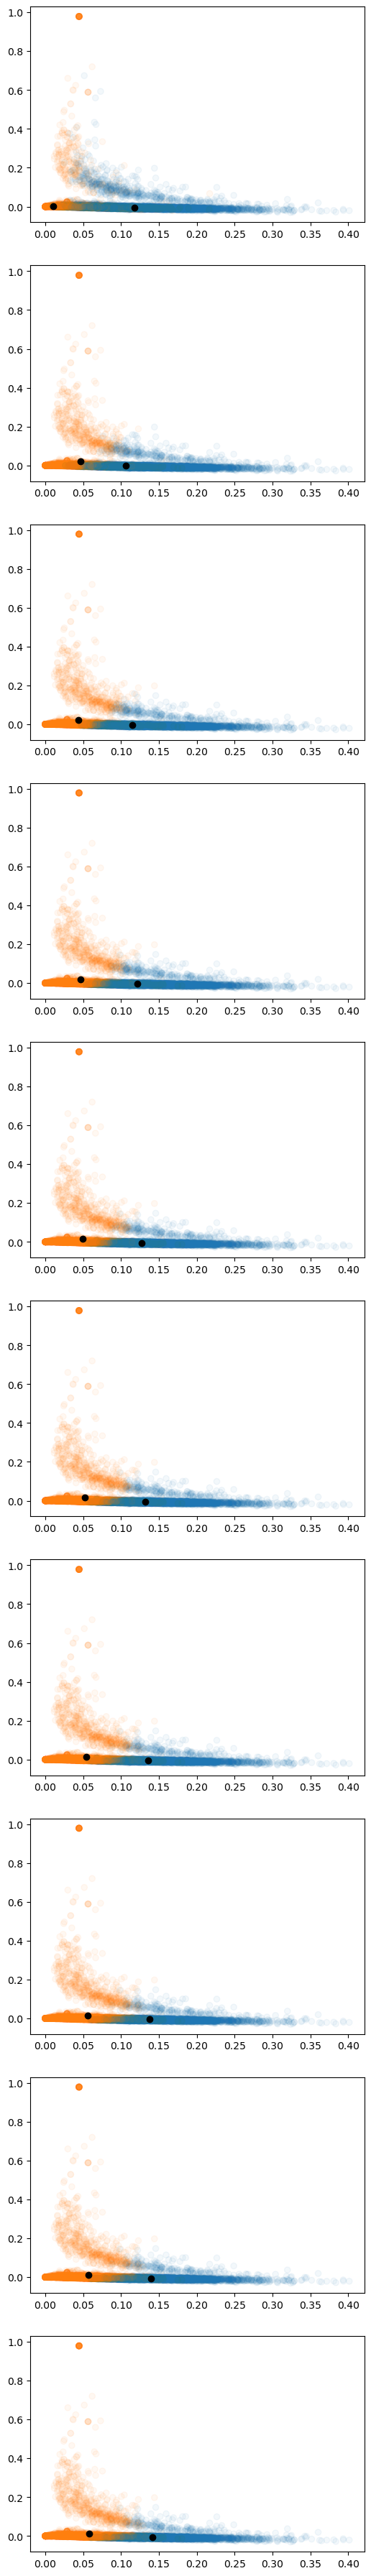

In [ ]:
tSVD = decomposition.TruncatedSVD(n_components=20)
X_tSVD_train = tSVD.fit_transform(X_train)
X_tSVD_test = tSVD.fit_transform(X_test)
kmeans_visualize(X_tSVD_test, k=2, max_iter=10, rand_seed=42)

We see that using a K-means clustering approach with k=2 produces two not very distinct clusters. The blue cluster seems to be rather long. Neither are very uniform in shape. Each iteration looks rather similar except the first one.

In [ ]:
tSVD = decomposition.TruncatedSVD(n_components=100)
X_tSVD_train = tSVD.fit_transform(X_train)
X_tSVD_test = tSVD.fit_transform(X_test)

(array([[ 1.44998382e-01, -6.30246116e-03, -7.84785044e-03,
         -5.50021394e-03,  2.62037649e-03, -9.41833283e-03,
          1.16862112e-02,  1.01465864e-04,  1.43339658e-03,
         -2.79041617e-03, -3.11774985e-03,  6.59990625e-04,
         -1.74889690e-03,  1.50423315e-03, -5.25499804e-04,
         -1.65619720e-03, -4.91978487e-04, -1.25897865e-05,
         -1.62587258e-03, -8.50486499e-04,  5.38882837e-04,
          1.12548485e-03, -4.25896862e-04,  6.91555123e-04,
          9.59534383e-04, -5.81986442e-04, -4.66498447e-04,
         -6.12516877e-04, -1.56349867e-03,  1.28531930e-03,
         -1.22579637e-03,  4.22600262e-04,  4.56507449e-04,
         -1.11159694e-04,  1.29092679e-03,  5.85299799e-05,
          3.36840339e-05, -4.19355338e-04, -1.51915833e-05,
         -3.84289846e-04,  3.13915935e-04,  8.11617264e-04,
         -5.33328541e-04, -9.98851316e-04, -3.92321781e-04,
         -1.87496451e-04,  3.35928501e-04,  7.17734609e-04,
         -4.58246881e-04,  7.27480765e-0

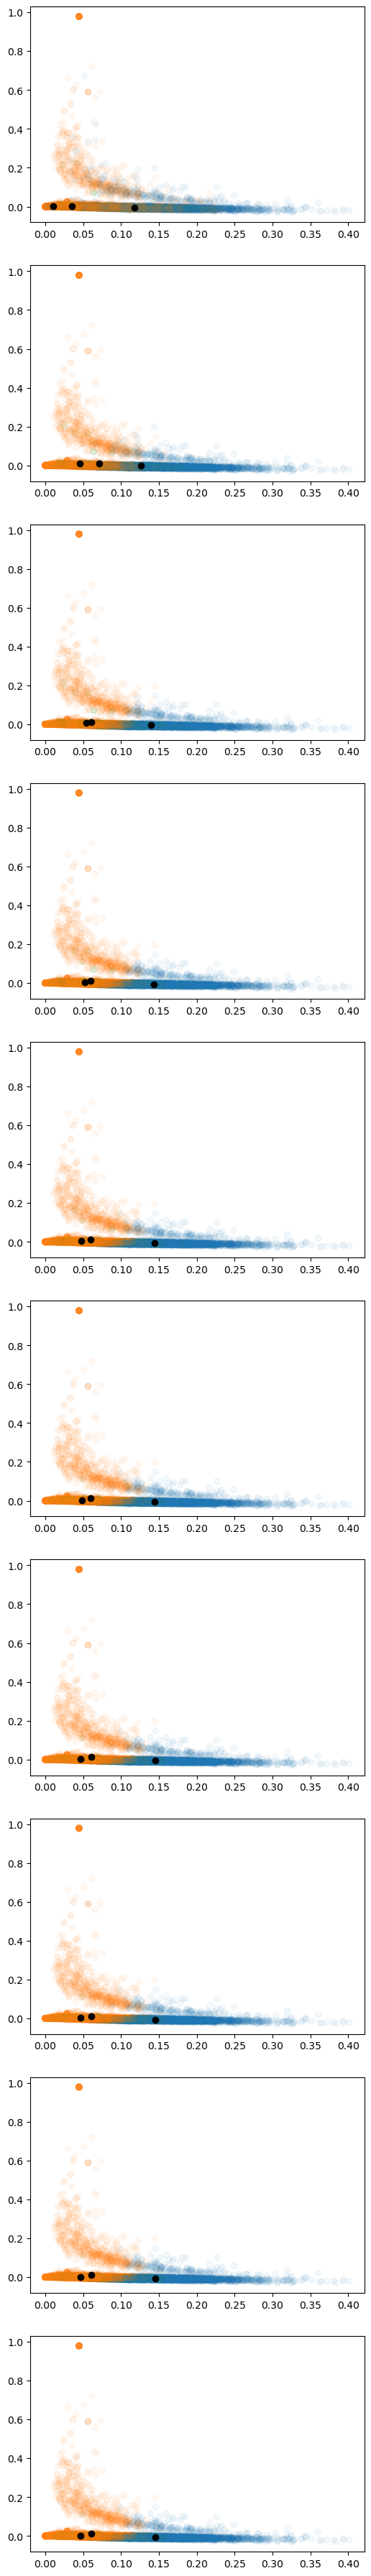

In [ ]:
kmeans_visualize(X_tSVD_test, k=3, max_iter=10, rand_seed=42)

Adding another cluster does not make the clusters more distinct, in fact, the green cluster is mostly masked by the orange.

## Latent Dirichlet Allocation (LDA)

In [ ]:
# # RUN ONCE
# #Apply our functions
# truth_df['tokenized_text'] = truth_df['cleaned_post_text'].apply(lambda x: lucem_illud.word_tokenize(x))
# truth_df['normalized_tokens'] = truth_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
# # RUN ONCE

# def dropMissing(wordLst, vocab):
#     return [w for w in wordLst if w in vocab]

# # find reduced tokens
# truth_df['reduced_tokens'] = truth_df['normalized_tokens'].apply(lambda x: dropMissing(x, tfidf_vectorizer.vocabulary_.keys()))
# truth_df.to_pickle("D:\\hw\\adopt-proj\\new_truth_df.pkl")

In [ ]:
# create a dictionary of words for a corpora
dict_adopt = gensim.corpora.Dictionary(truth_df['reduced_tokens'])

# create the corpus
adopt_corpus = [dict_adopt.doc2bow(text) for text in truth_df['reduced_tokens']]

In [ ]:
# we will serialize and load the current corpus
gensim.corpora.MmCorpus.serialize('adopt.mm', adopt_corpus)
adoptmm = gensim.corpora.MmCorpus('adopt.mm')

In [ ]:
# lets apply the LDA
adopt_lda = gensim.models.ldamodel.LdaModel(corpus=adoptmm, id2word=dict_adopt, 
                                            num_topics=4, alpha="auto", eta="auto")

In [ ]:
ldaDF = pd.DataFrame({
        'truth_df' : truth_df['title'],
        'topics' : [adopt_lda[dict_adopt.doc2bow(l)] for l in truth_df['reduced_tokens']]
    })

Let's see what the most commons words in each topic are

In [ ]:
a_topicsDict = {}
for topicNum in range(adopt_lda.num_topics):
    topicWords = [w for w, p in adopt_lda.show_topic(topicNum)]
    a_topicsDict[f'Topic_{topicNum}'] = topicWords

wordRanksDF_a = pd.DataFrame(a_topicsDict)
wordRanksDF_a

,Topic_0,Topic_1,Topic_2,Topic_3
0,know,child,adoptee,adoption
1,family,parent,adoption,https
2,mom,adopt,feel,foster
3,find,adoption,think,child
4,bio,family,people,com
5,like,want,like,agency
6,want,adoptive,post,www
7,tell,people,experience,adopt
8,birth,think,comment,state
9,year,kid,know,care


We see that I failed to properly clean the data all the way ("https" appears when I thought I removed all links). BUT we also see that Topic0 appears to be about birth search, Topic1 is possibly about prospective adoptive parents, Topic2 is about the experiences of adoption, and topic3 are posts containing links to other resources on adoption (oops).

## Conclusion

Overall I am quite disappointed with the performance of these models after using dimension reducing techniques. It seems that the data is much too complex to be properly reduced in dimension by this much, perhaps I tried more dimensions (> 1000) it would work better. But as it stands now, reducing the dimensions to 100 or even further to 20, there is just too much information lost to have a good model. 